#### In this notebook, we used data from 3 datasets containing OCT images, 
 1.  #### Kermany (Retinal_OCT2017)
 2.  #### Duke Srinivasan 2014
 3.  #### Tehran Rabbani 2018
 
 We perform classification on 3 classes: AMD, DR and NORMAL

#### Test set is the Dataverse Dataset

We take 2 new datasets and merge with the entire kermany18 dataset. We train on the OpticNet model from scratch and obtain 96% training accuracy and 93.6% validation accuracy. We test the model on the Dataverse dataset which serves as our offsite testing set and obtain 61% accuracy showing that the model has only learnt based on data it was given and cannot generalize to OCT scans that are different to the ones it has seen. This shows that pretraining on Imagenet ends up helping the model better generalize to other OCT scans sugge

# Importing Data & Libraries

In [1]:
p = "/kaggle/input/kermany2018/OCT2017 /train"
p1 = "/kaggle/input/ai-in-healthcare-hackathon/DataVerse_Dataset/DataVerse_Dataset"
p2 = '/kaggle/input/ai-in-healthcare-hackathon/OCT_Dataset_Duke_Srinivasan_2014'
p3 = "/kaggle/input/ai-in-healthcare-hackathon/OCT_Dataset_Tehran_Rabbani_2018"

In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization, ReLU
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet50, InceptionResNetV2
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow_addons as tfa

import matplotlib.cm as cm
from IPython.display import Image, display

import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# Data Pre Processing & Visualization

In [3]:
new_class = {'CNV':'AMD', 'AMD':'AMD', 'DME':'DR', 'NORMAL':'NORMAL'}

In [4]:
data_path = []
data_label = []

for i in ['DME', 'CNV', 'NORMAL']:
    path = os.path.join(p, i)
    for j in tqdm(os.listdir(path)):
        data_path.append(os.path.join(path, j))
        data_label.append(new_class[i])

100%|██████████| 26315/26315 [00:00<00:00, 388443.49it/s]


In [5]:
for i in ['DME', 'AMD', 'NORMAL']:
    path = os.path.join(p2, i)
    for j in tqdm(os.listdir(path)):
        data_path.append(os.path.join(path, j))
        data_label.append(new_class[i])

100%|██████████| 1407/1407 [00:00<00:00, 376100.04it/s]


In [6]:
for i in ['DME', 'AMD', 'NORMAL']:
    path = os.path.join(p3, i)
    for j in tqdm(os.listdir(path)):
        data_path.append(os.path.join(path, j))
        data_label.append(new_class[i])

100%|██████████| 1585/1585 [00:00<00:00, 370092.51it/s]


In [7]:
def labeller(j):
    if j.startswith("AMRD"): return 'AMD'
    elif j.startswith("DR"): return 'DR'
    else: return 'NORMAL'

In [8]:
test_path = []
test_label = []
for i in ['Macular Degeneration', 'Diabetic_Retinopathy','Normal_retina']:
    full_path = os.path.join(p1,i)
    img_dir = os.listdir(full_path)
    for j in img_dir:
        test_path.append(os.path.join(full_path, j))
        test_label.append(labeller(j))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(data_path, data_label, test_size=0.1, random_state=42)
df_train = pd.DataFrame(list(zip(X_train, y_train)),columns =['image_path', 'label'])
df_val = pd.DataFrame(list(zip(X_val, y_val)),columns =['image_path', 'label'])
df_test = pd.DataFrame(list(zip(test_path, test_label)),columns =['image_path', 'label'])

Training Data

<AxesSubplot:xlabel='label', ylabel='count'>

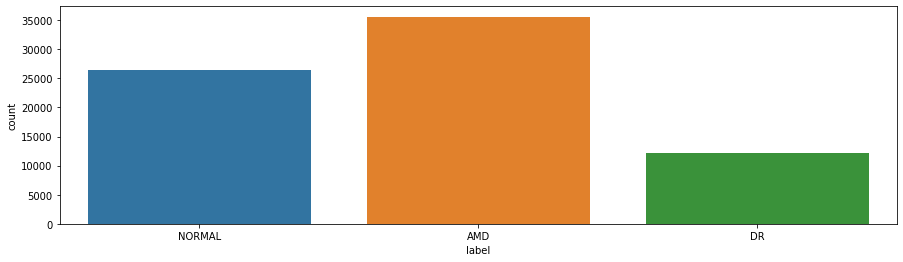

In [10]:
plt.rcParams["figure.figsize"] = (15,4)
df = df_train
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

<AxesSubplot:xlabel='label', ylabel='count'>

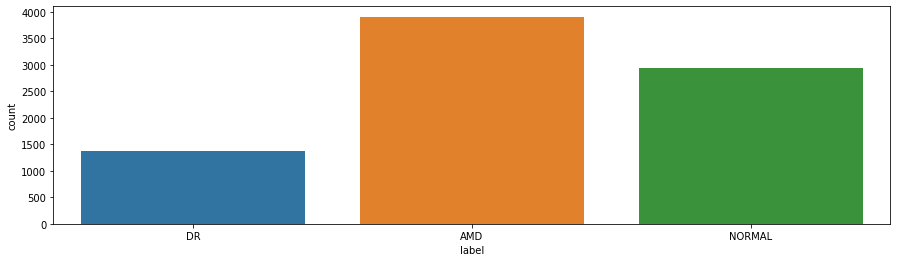

In [11]:
plt.rcParams["figure.figsize"] = (15,4)
df = df_val
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

Test Data

<AxesSubplot:xlabel='label', ylabel='count'>

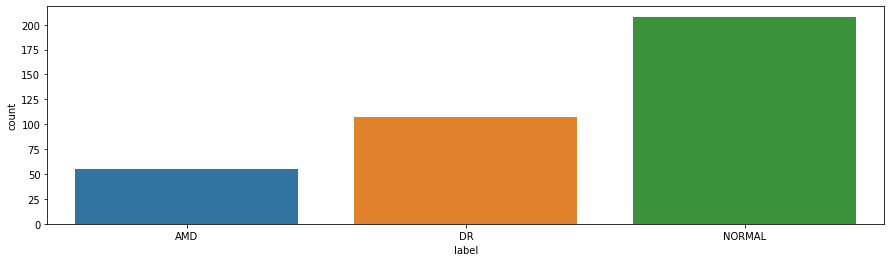

In [12]:
plt.rcParams["figure.figsize"] = (15,4)
df = df_test
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

## Data Augmentation

In [13]:
train_aug = ImageDataGenerator(
        rotation_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        rescale=1.0/255,
        horizontal_flip=True,
        fill_mode='nearest')

test_aug = ImageDataGenerator(
    rescale = 1.0/255,)

train_generator= train_aug.flow_from_dataframe(
        dataframe=df_train,
        x_col="image_path",
        y_col="label",
        batch_size=8,
        color_mode="rgb",
        shuffle = True,
        target_size = (224, 224),
        class_mode="categorical")

val_generator= test_aug.flow_from_dataframe(
        dataframe=df_val,
        x_col="image_path",
        y_col="label",
        color_mode="rgb",
        batch_size=8,
        shuffle = False, 
        target_size = (224, 224),
        class_mode="categorical")

test_generator= test_aug.flow_from_dataframe(
        dataframe=df_test,
        x_col="image_path",
        y_col="label",
        color_mode="rgb",
        batch_size=8,
        shuffle = False, 
        target_size = (224, 224),
        class_mode="categorical")

Found 74117 validated image filenames belonging to 3 classes.
Found 8236 validated image filenames belonging to 3 classes.
Found 368 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# MODEL
## Compiling & Training

In [14]:
from keras.layers import Input, Multiply,GlobalAveragePooling2D, Add, Dense, Activation, Maximum, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Lambda, UpSampling2D, DepthwiseConv2D, SeparableConv2D
from keras.optimizers import Adam
from keras.initializers import glorot_uniform

def res_conv(X, filters, base, s):
    
    name_base = base + '/branch'
    
    F1, F2, F3 = filters

    ##### Branch1 is the main path and Branch2 is the shortcut path #####
    
    X_shortcut = X
    
    ##### Branch1 #####
    # First component of Branch1 
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_1')(X)
    X= Activation('relu', name=name_base + '1/relu_1')(X)
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)

    # Second component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_2')(X)
    X = Activation('relu', name=name_base + '1/relu_2')(X)
    X = Conv2D(filters=F2, kernel_size=(2,2), strides=(s,s), padding='same', name=name_base + '1/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Third component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_3')(X)
    X = Activation('relu', name=name_base + '1/relu_3')(X)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)
    
    ##### Branch2 ####
    X_shortcut = BatchNormalization(axis=-1, name=name_base + '2/bn_1')(X_shortcut)
    X_shortcut= Activation('relu', name=name_base + '2/relu_1')(X_shortcut)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', name=name_base + '2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    
    # Final step: Add Branch1 and Branch2
    X = Add(name=base + '/Add')([X, X_shortcut])

    return X

def res_identity(X, filters, base):
    
    name_base = base + '/branch'
    
    F1, F2, F3 = filters

    ##### Branch1 is the main path and Branch2 is the shortcut path #####
    
    X_shortcut = X
    
    ##### Branch1 #####
    # First component of Branch1 
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_1')(X)
    Shortcut= Activation('relu', name=name_base + '1/relu_1')(X)
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_1', kernel_initializer=glorot_uniform(seed=0))(Shortcut)

    # Second component BranchOut 1
    X1 = BatchNormalization(axis=-1, name=name_base + '1/ConvBn_2')(X)
    X1 = Activation('relu', name=name_base + '1/ConvRelu_2')(X1)
    X1 = Conv2D(filters=F2, kernel_size=(2,2), dilation_rate=(2, 2),strides=(1,1), padding='same', name=name_base + '1/Conv_2', kernel_initializer=glorot_uniform(seed=0))(X1)
    
    # Second component BrancOut 2
    X2 = BatchNormalization(axis=-1, name=name_base + '1/SepBn_2')(X)
    X2 = Activation('relu', name=name_base + '1/SepRelu_2')(X2)
    X2 = SeparableConv2D(filters=F2, kernel_size=(2,2), dilation_rate=(2, 2),strides=(1,1), padding='same', name=name_base + '1/SepConv_2', kernel_initializer=glorot_uniform(seed=0))(X2)
    
    # Second component Add-BranchOut
    X = Add(name=base + '/Add-2branches')([X1, X2])
    
    # Third component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_3')(X)
    X = Activation('relu', name=name_base + '1/relu_3')(X)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)    
    
    # Final step: Add Branch1 and the original Input itself
    X = Add(name=base + '/Add')([X_shortcut,X])

    return X

def EncoderDecoder(X, name_base):
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name = name_base + '/Downsample1')(X)
    #X = Conv2D(outgoing_depth, (2,2), strides=(1,1), dilation_rate=(2,2), padding='same', name = name_base + '/DC1', kernel_initializer=glorot_uniform(seed=0))(X)    
    X = UpSampling2D(size=(2, 2),interpolation='bilinear',name = name_base + '/Upsample1')(X)
    X = Activation('sigmoid', name = name_base + '/Activate')(X)
    return X

def RDBI(X, filters, base, number):
    
    for i in range(number):
        X = res_identity(X, filters, base+ '/id_'+str(1+i))
    
    return X
def OpticNet(input_size,num_of_classes):
    input_shape=(input_size, input_size, 3) # Height x Width x Channel
    X_input = Input(input_shape)
    X = Conv2D(64, (7,7), strides=(2,2), padding='same', name ='CONV1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=-1, name ='BN1')(X)
    X = Activation('relu', name ='RELU1')(X)
    X = res_conv(X, [64,64,256], 'RC0', 1)
    
    # MID 1
    X1 = EncoderDecoder(X, 'EncoderDecoder1')
    X2 = RDBI(X, [32,32,256], 'RDBI1',4)
    X = Multiply(name = 'Mutiply1')([X1,X2])
    X = Add(name = 'Add1')([X,X1,X2])
    X = res_conv(X, [128,128,512], 'RC1', 2)
    
    # MID 2
    X1 = EncoderDecoder(X, 'EncoderDecoder2')
    X2 = RDBI(X, [64,64,512], 'RDBI2',4)
    X = Multiply(name = 'Mutiply2')([X1,X2])
    X = Add(name = 'Add2')([X,X1,X2])
    X = res_conv(X, [256,256,1024], 'RC2', 2)
    
    # MID 3
    X1 = EncoderDecoder(X, 'EncoderDecoder3')
    X2 = RDBI(X, [128,128,1024], 'RDBI3',3)
    X = Multiply(name = 'Mutiply3')([X1,X2])
    X = Add(name = 'Add3')([X,X1,X2])
    X = res_conv(X, [512,512,2048], 'RC3', 2)
    
    # MID 4
    X1 = EncoderDecoder(X, 'EncoderDecoder4')
    X2 = RDBI(X, [256,256,2048], 'RDBI4',3)
    X = Multiply(name = 'Mutiply4')([X1,X2])
    X = Add(name = 'Add4')([X,X1,X2]) 
    
    X = GlobalAveragePooling2D(name='global_avg_pool')(X)
    X = Dense(256, name='Dense_1')(X)
    X = Dense(num_of_classes, name='Dense_2')(X)
    X = Activation('softmax', name='classifier')(X)
    
    model = Model(inputs=X_input, outputs=X, name='')

    return model

In [15]:
def train_model(model, train_generator, test_generator, num_epochs, optimizer, class_weights):
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_lr=1e-8, mode='auto')
    model.summary()
    
    # Train using .fit
    history = model.fit(train_generator, epochs=num_epochs, 
                        validation_data=test_generator, class_weight = class_weights, steps_per_epoch=289, validation_steps=73, verbose=1,
                        callbacks = [early_stop, rlr])
    
    return model, history

# Model Evaluation
## Plotting Curves - Loss, Accuracy, ROC + Confusion Matrix

In [16]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
# It prints & plots the confusion matrix, normalization can be applied by setting normalize=True.
    
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    for i in range(num_classes):
        fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        c_ax.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_labels[i], roc_auc[i]))
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        c_ax.set_title('ROC curve of class {0}'.format(class_labels[i]))
        c_ax.legend(loc="lower right")
        plt.show()
    return roc_auc_score(y_test, y_pred)

In [17]:
def evaluate_model(model, history, test_generator):
    # Evaluate model
    score = model.evaluate(test_generator, verbose=0)
    print('\nTest set accuracy:', score[1], '\n')
    
    y_true = np.array(test_generator.labels)
    y_pred = model.predict(test_generator, verbose = 1)
    y_pred_classes = np.argmax(y_pred,axis = 1)
    class_labels = list(test_generator.class_indices.keys())   
    
    print('\n', sklearn.metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = class_labels)
    plt.show()
    print("ROS AUC score:", plot_roc_curves(y_true, y_pred,3, class_labels))

# Transfer Learning using OpticNet

Compilation

In [18]:
opticnet_model = OpticNet(224,3)

Training

In [19]:
opticnet_model, opticnet_history = train_model(opticnet_model, train_generator, val_generator, 30, Adam(lr=.0001), None)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
CONV1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 112, 112, 64) 256         CONV1[0][0]                      
__________________________________________________________________________________________________
RELU1 (Activation)              (None, 112, 112, 64) 0           BN1[0][0]                        
______________________________________________________________________________________________

Evaluation


Test set accuracy: 0.6086956262588501 

46/46 [==============================] - 5s 83ms/step

              precision    recall  f1-score   support

         AMD       0.28      1.00      0.44        55
          DR       1.00      0.65      0.79       107
      NORMAL       0.94      0.48      0.64       206

    accuracy                           0.61       368
   macro avg       0.74      0.71      0.62       368
weighted avg       0.86      0.61      0.65       368



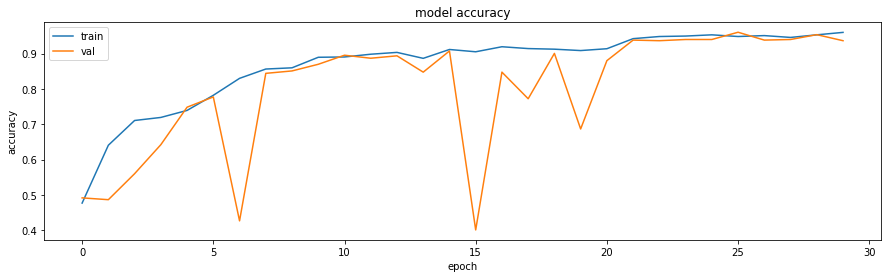

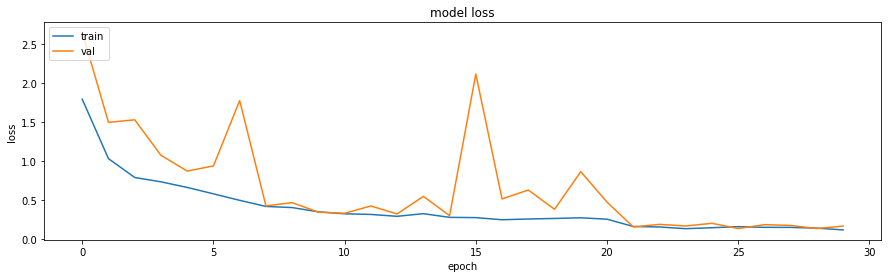

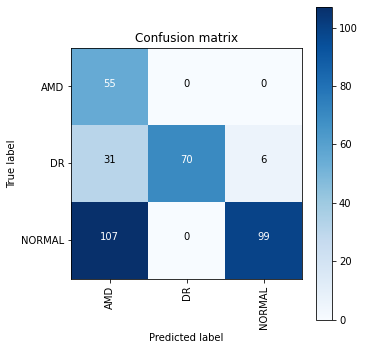

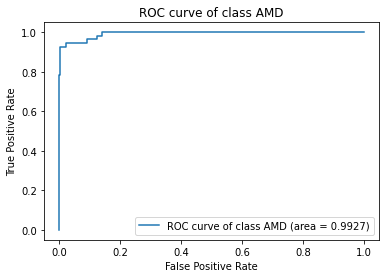

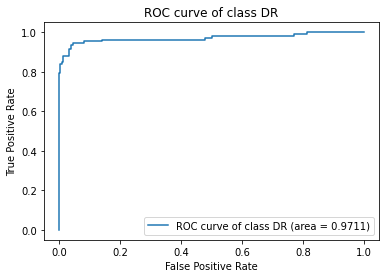

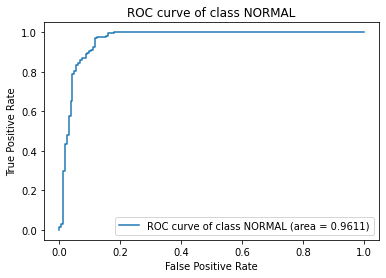

ROS AUC score: 0.9749630510398498


In [20]:
evaluate_model(opticnet_model, opticnet_history, test_generator)

In [21]:
opticnet_model.save("/kaggle/working/opticnet.h5")

# Model Interpretability using Grad CAM

One way to ensure the model is performing correctly is to debug your model and visually validate that it is “looking” and “activating” at the correct locations in an image.

Selvaraju et al. published a novel paper entitled, Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization (https://arxiv.org/abs/1610.02391). 

GRAD-CAM works by (1) finding the final convolutional layer in the network and then (2) examining the gradient information flowing into that layer.

The output of Grad-CAM is a heatmap visualization for a given class label (either the top, predicted label or an arbitrary label we select for debugging). We can use this heatmap to visually verify where in the image the CNN is looking.

In [22]:
image_path= df_test['image_path'][100]

img = load_img(image_path, target_size=(224,224,3)) # stores image in PIL format
image_array=img_to_array(img)

Display Original Image

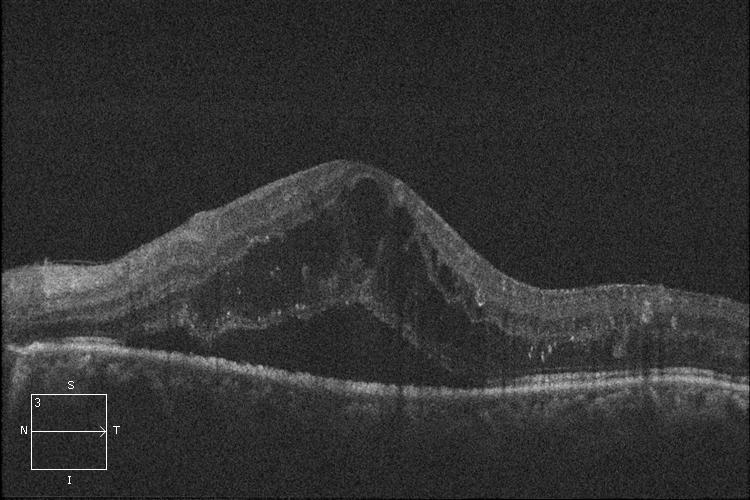

In [23]:
display(Image(image_path))

GRAD CAM Algorithm

In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.layers[-2].output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Create Heat Map

In [25]:
# Make model
model = opticnet_model

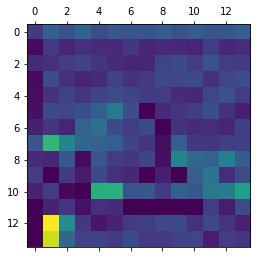

In [26]:
last_conv_layer_name ="Add4"
# Remove last layer's softmax
model.layers[-1].activation = None

img_array=np.expand_dims(image_array, axis=0)
# Prepare particular image 

# Generate class activation heatmap
heatmap= make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [27]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


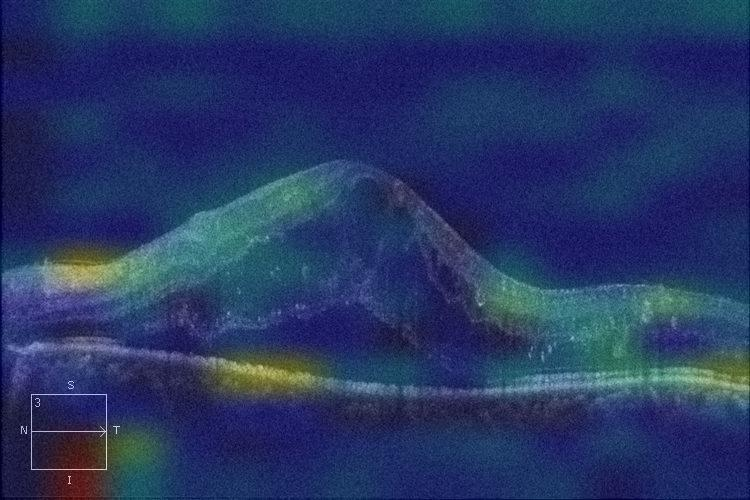

In [28]:
save_and_display_gradcam(image_path, heatmap,cam_path="/kaggle/working/GradCamTest.jpg")